## Import e download dei dati

This block imports all the necessary libraries for data collection, manipulation, visualization, and statistical modeling.
We define a set of financial market tickers, including the S&P 500 index, Treasury yields, crude oil prices, the U.S. Dollar Index, and gold futures.

Using the yfinance API, we download daily historical price data for the period 2015–2025.
The Close prices are then extracted from the downloaded dataset, forming the basis for the return calculations used in the regression analysis.

Finally, the first rows of the dataset are displayed to verify that the data has been downloaded correctly.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Symbols:
# ^GSPC = S&P500
# ^TNX  = 10yr Treasury Yield
# CL=F  = Crude Oil WTI
# DX-Y.NYB = Dollar Index (DXY)
# GC=F = Gold Futures

tickers = ["^GSPC", "^TNX", "CL=F", "DX-Y.NYB", "GC=F"]
data: pd.DataFrame | None = yf.download(
    tickers, start="2015-01-01", end="2025-01-01", progress=False
)

assert data is not None
close = data["Close"]
print(close.head())

/tmp/ipykernel_6680/1121848654.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data: pd.DataFrame | None = yf.download(


Ticker           CL=F   DX-Y.NYB         GC=F        ^GSPC   ^TNX
Date                                                             
2015-01-02  52.689999  91.080002  1186.000000  2058.199951  2.123
2015-01-05  50.040001  91.379997  1203.900024  2020.579956  2.039
2015-01-06  47.930000  91.500000  1219.300049  2002.609985  1.963
2015-01-07  48.650002  91.889999  1210.599976  2025.900024  1.954
2015-01-08  48.790001  92.370003  1208.400024  2062.139893  2.016


## Pulizia dati e costruzione variabili

This block computes daily log-returns for all selected financial time series.
We first calculate the ratio between each asset’s closing price and its previous day value, and then apply the natural logarithm to obtain log-returns.

The resulting data is explicitly converted into a pandas DataFrame and cleaned by removing missing values.
To improve readability, the columns are renamed according to the corresponding economic variables: oil prices, dollar index, gold prices, the S&P 500, and Treasury yields.

Finally, the first rows of the returns dataset are printed to confirm that the transformation was applied correctly.

In [2]:
# log-returns giornalieri
ratio = close / close.shift(1)
log_ratio = np.log(ratio)

# Cast esplicito per Pylance
returns = pd.DataFrame(log_ratio).dropna()

# Rinomino le colonne con nomi più parlanti
# Ordine attuale: CL=F, DX-Y.NYB, GC=F, ^GSPC, ^TNX
returns.columns = ["Oil", "Dollar", "Gold", "SP500", "Yield"]

print(returns.head())

                 Oil    Dollar      Gold     SP500     Yield
Date                                                        
2015-01-05 -0.051603  0.003288  0.014980 -0.018447 -0.040371
2015-01-06 -0.043081  0.001312  0.012711 -0.008933 -0.037986
2015-01-07  0.014910  0.004253 -0.007161  0.011563 -0.004595
2015-01-08  0.002874  0.005210 -0.001819  0.017730  0.031237
2015-01-09 -0.008852 -0.004666  0.006270 -0.008439 -0.022574


/home/mattegiorgi/docs/rts/.venv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## Definizione della regressione

In this block, we set up and estimate the multiple linear regression model. The daily log-returns of the S&P 500 index are selected as the dependent variable.

The independent variables include changes in Treasury yields, oil prices, the U.S. Dollar Index, and gold prices, representing key macro-financial factors.

An intercept term is added to the design matrix, and the model is fitted using Ordinary Least Squares (OLS) via the statsmodels library.
The regression summary is printed to provide coefficient estimates, significance levels, and overall model diagnostics.

$$
R_{\mathrm{SP500},t} = \beta_0 + \beta_1 \Delta\mathrm{Yield}_t + \beta_2 \Delta\mathrm{Oil}_t + \beta_3 \Delta\mathrm{Dollar}_t + \beta_4 \Delta\mathrm{Gold}_t + u_t
$$

In [3]:
# variabile dipendente: rendimento S&P500
y = returns["SP500"]

# regressori: tasso, petrolio, dollar index, oro
X = returns[["Yield", "Oil", "Dollar", "Gold"]]

# aggiungo l'intercetta
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     107.4
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           1.49e-84
Time:                        18:04:33   Log-Likelihood:                 7886.5
No. Observations:                2506   AIC:                        -1.576e+04
Df Residuals:                    2501   BIC:                        -1.573e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.873      0.0

## Heatmap delle correlazioni

This block computes and visualizes the correlation matrix of all log-return series.
The corr() function is used to quantify linear relationships between the S&P 500 returns and the selected macro-financial variables.

A heatmap is then generated using Seaborn to provide a clear and intuitive graphical representation of the correlation structure.

The color scale helps highlight positive and negative correlations, offering useful insights into the interdependencies among the variables before running more advanced diagnostics.

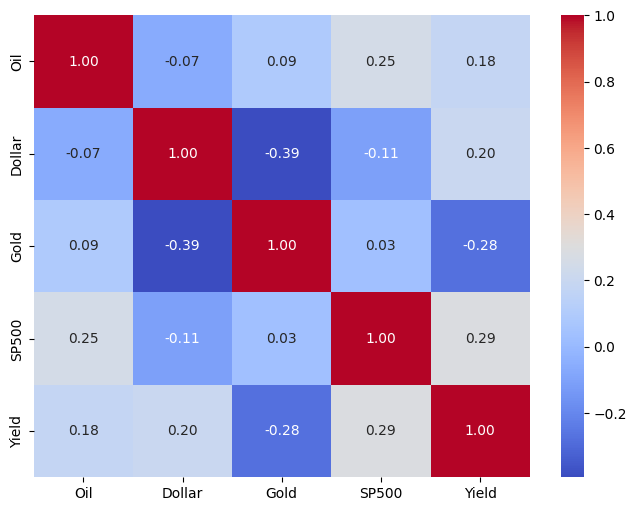

In [4]:
# Adesso il linter è felice
corr_matrix = returns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

## Fitted vs Residuals (diagnostica OLS)

This block performs a residual diagnostics check by plotting residuals against the fitted values of the regression model.
The scatter plot helps assess whether the assumptions of linearity and homoscedasticity are reasonably satisfied.

A horizontal reference line at zero residuals is added to highlight potential patterns or deviations.
If the residuals appear randomly scattered around the zero line without clear structure, it indicates that the linear model is appropriately specified.

This visualization is a standard tool for evaluating the quality of the regression fit.

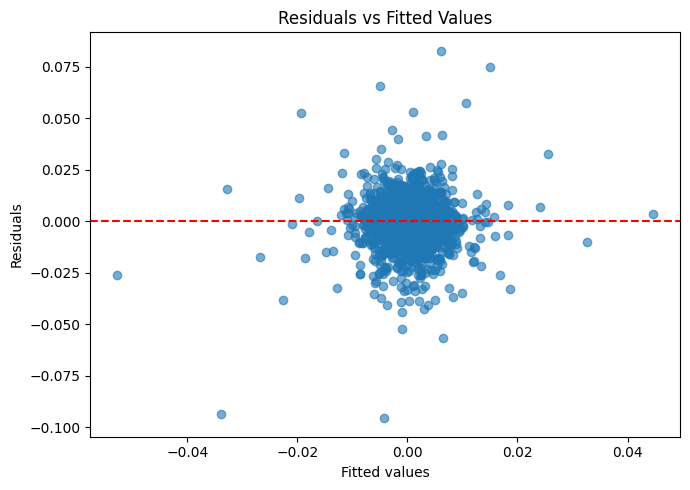

In [5]:
fitted = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(7, 5))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

## Computo del Variance Inflation Factor (VIF)

This block computes the Variance Inflation Factor (VIF) for each explanatory variable in the regression model.
The design matrix X is cast to a pandas DataFrame to ensure compatibility with downstream operations.

The VIF measures how strongly each variable is linearly related to the others, providing a diagnostic for multicollinearity.

A VIF value substantially greater than 10 typically indicates problematic collinearity that may distort coefficient estimates.
The resulting table lists all regressors alongside their corresponding VIF values, helping evaluate the stability of the model.

In [6]:
vif_df = pd.DataFrame()

# Cast esplicito per Pylance (evita warning)
X = pd.DataFrame(X)

vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df

,variable,VIF
0,const,1.002645
1,Yield,1.150311
2,Oil,1.060680
3,Dollar,1.200340
4,Gold,1.264135
